In [ ]:
# hide
# all_tutorial

# Tutorial - RL Train Cycle Overview

>Overview of the RL training cycle

## RL Train Cycle Overview

The goal of this tutorial is to walk through the RL fit cycle to familiarize ourselves with the `Events` cycle and get a better understanding of how `Callback` and `Environment` classes work.

## High Level Overview

### The Environment

At the highest level, we have the `Environment` class. The `Environment` holds together several sub-modules and orchestrates them during the fit loop. The following are contained in the `Environment`:
- `agent` - This is the actual model we're training
- `template_cb` - this holds a `Template` class that we use to define our chemical space
- `samplers` - samplers generate new samples to train on
- `buffer` - the buffer collects and distributes samples from all the `samplers`
- `rewards` - rewards score samples
- `losses` - losses generate values we can backpropagate through 
- `log` - the log holds a record of all samples in the training process

### Callbacks and the Event Cycle

Each one of the above items is a `Callback`. A `Callback` is a a general class that can hook into the `Environment` fit cycle at a number of pre-defined `Events`. When the `Environment` calls a specific `Event`, the event name is passed to every callback in the `Environment`. If a given `Callback` has a defined function named after the event, that function is called. This creates a very flexible system for customizing training loops.

We'll be looking more at `Events` later. For now, we'll just list them in brief. These are the events called during the RL training cycle in the order they are executed:

- `setup` - called when the `Environment` is created, used to set up values
- `before_train` - called before training is started
- `build_buffer` - draws samples from `samplers` into the `buffer`
- `filter_buffer` - filters samples in the buffer
- `after_build_buffer` - called after buffer filtering. Used for cleanup, logging, etc
- `before_batch` - called before a batch starts, used to set up the `batch state`
- `sample_batch` - samples are drawn from `sampers` and `buffer` into the `batch state`
- `before_filter_batch` - allows preprocessing of samples before filtering
- `filter_batch` - filters samples in `batch state`
- `after_sample` - used for calculating sampling metrics
- `before_compute_reward` - used to set up any values needed for reward computation 
- `compute_reward` - used by `rewards` to compute rewards for all samples in the `batch state`
- `after_compute_reward` - used for logging reward metrics
- `reward_modification` - modify rewards in ways not tracked by the log
- `get_model_outputs` - generate necessary tensors from the model
- `after_get_model_outputs` - used for any processing required prior to loss calculation 
- `compute_loss` - compute loss values
- `zero_grad` - zero grad
- `before_step` - used for computation before optimizer step (ie gradient clipping)
- `step` - step optimizer
- `after_batch` - compute batch stats
- `after_train` - final event after all training batches

In [ ]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
set_global_pool(10)

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     ChargeFilter(None, 0)],
                    [QEDFilter(0.5, None, score=1.),
                     SAFilter(None, 5, score=1.)], 
                    fail_score=-10., log=False)

template_cb = TemplateCallback(template, prefilter=True)

In [ ]:
class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        return preds
    
reward_function = FP_Regression_Score('files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=10.)

aff_reward = RewardCallback(reward, 'aff')

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)

loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [ ]:
agent = LSTM_LM_Small_ZINC(drop_scale=0.5,opt_kwargs={'lr':5e-5})

In [ ]:
gen_bs = 1500
df = pd.read_csv('untracked_files/affinity_data_set.csv')
df = df[df.value<-1]

sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 1000, 0.5, gen_bs)
sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = DatasetSampler(df.smiles.values, 'erbB1_data', buffer_size=4)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)
new_cb = NoveltyReward(weight=0.05)

cbs = [new_cb, supervised_cb, live_p90, live_max]

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=[loss],
                 cbs=cbs)

In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
0,-6.087,-6.087,1.000,1.000,192,1.953,0.960,1.000,0.920,-6.183,1.000,-8.040,0.050,2.763,-1.641,5.840
10,-5.822,-5.822,1.000,1.000,192,1.948,0.960,1.000,0.920,-6.090,1.000,-7.770,0.050,2.948,-0.944,3.568
20,-5.890,-5.890,0.974,1.000,194,1.969,0.970,1.000,0.940,-5.858,1.000,-7.859,0.049,3.360,-2.032,4.165
30,-5.745,-5.745,0.974,1.000,195,1.944,0.975,1.000,0.950,-5.644,1.000,-7.689,0.049,3.805,-0.816,6.366
40,-5.033,-5.033,0.968,1.000,190,1.968,0.950,1.000,0.900,-5.005,1.000,-7.001,0.048,3.253,-0.490,4.096
50,-5.532,-5.532,0.958,1.000,189,1.942,0.945,1.000,0.890,-5.952,1.000,-7.474,0.048,3.628,-1.398,5.620
60,-5.915,-5.915,0.979,1.000,192,1.974,0.960,1.000,0.920,-5.352,1.000,-7.889,0.049,2.815,-1.400,2.692
70,-5.762,-5.762,0.979,1.000,188,1.947,0.940,1.000,0.880,-5.591,1.000,-7.709,0.049,3.051,-1.036,4.640
80,-5.658,-5.658,0.969,1.000,192,1.958,0.960,1.000,0.920,-5.744,1.000,-7.617,0.048,2.772,-1.222,2.692
90,-5.889,-5.889,0.980,1.000,196,1.964,0.980,1.000,0.960,-5.740,1.000,-7.853,0.049,2.599,-1.484,2.312


Epoch,Train Loss,Valid Loss,Time
0,0.36199,0.37252,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.44550,0.36852,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.32485,0.37060,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.33450,0.36753,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.31795,0.36277,00:07


In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
1000,-5.426,-5.426,0.968,1.000,188,1.973,0.940,1.000,0.880,-5.761,1.000,-7.400,0.048,3.976,-1.664,6.999
1010,-5.387,-5.387,0.980,1.000,197,1.975,0.985,1.000,0.970,-5.064,1.000,-7.361,0.049,3.394,-0.690,7.375
1020,-5.804,-5.804,0.979,1.000,191,1.958,0.955,1.000,0.910,-6.161,1.000,-7.762,0.049,3.868,0.133,6.573
1030,-5.449,-5.449,0.975,1.000,197,1.975,0.985,1.000,0.970,-5.566,1.000,-7.423,0.049,13.772,-0.604,3.443
1040,-4.872,-4.872,0.959,1.000,195,1.964,0.975,1.000,0.950,-5.055,0.989,-6.836,0.048,168.440,-0.178,7.545
1050,-4.656,-4.656,0.953,1.000,193,1.969,0.965,1.000,0.930,-5.302,1.000,-6.624,0.048,4.373,0.116,4.280
1060,-4.933,-4.933,0.974,1.000,192,1.958,0.960,1.000,0.920,-5.200,1.000,-6.891,0.049,3.222,-0.366,3.659
1070,-5.150,-5.150,0.974,1.000,193,1.964,0.965,1.000,0.930,-5.325,1.000,-7.114,0.049,3.300,-0.150,3.849
1080,-5.546,-5.546,0.979,1.000,194,1.964,0.970,1.000,0.940,-5.845,1.000,-7.510,0.049,3.959,-1.885,4.840
1090,-5.726,-5.726,0.990,1.000,195,1.954,0.975,1.000,0.950,-5.842,1.000,-7.680,0.049,3.912,-1.581,3.918


Epoch,Train Loss,Valid Loss,Time
0,0.38399,0.29478,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.33577,0.34575,00:08


Epoch,Train Loss,Valid Loss,Time
0,0.34737,0.28155,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.28066,0.31344,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.29646,0.28159,00:10


In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
2000,-4.324,-4.324,0.980,1.000,197,1.959,0.985,1.000,0.970,-4.180,1.000,-6.284,0.049,4.697,1.193,7.067
2010,-4.062,-4.062,0.980,1.000,199,1.980,0.995,1.000,0.990,-4.425,1.000,-6.042,0.049,259.402,0.812,7.164
2020,-3.803,-3.803,0.985,1.000,197,1.980,0.985,1.000,0.970,-4.589,1.000,-5.783,0.049,4.861,1.956,6.237
2030,-4.110,-4.110,0.974,1.000,195,1.969,0.975,1.000,0.950,-4.619,1.000,-6.079,0.049,4.349,1.230,5.201
2040,-4.094,-4.094,0.980,1.000,196,1.974,0.980,1.000,0.960,-4.305,1.000,-6.069,0.049,3.412,0.948,3.862
2050,-4.207,-4.207,0.974,1.000,195,1.979,0.975,1.000,0.950,-4.108,1.000,-6.186,0.049,4.243,1.996,8.849
2060,-4.272,-4.272,0.984,1.000,193,1.974,0.965,1.000,0.930,-4.605,1.000,-6.246,0.049,4.154,-0.261,11.020
2070,-3.913,-3.913,0.985,1.000,194,1.954,0.970,1.000,0.940,-4.504,1.000,-5.867,0.049,4.024,0.919,8.544
2080,-3.826,-3.826,0.990,1.000,194,1.959,0.970,1.000,0.940,-4.116,1.000,-5.785,0.049,3.365,2.026,9.339
2090,-4.178,-4.178,0.969,1.000,193,1.964,0.965,1.000,0.930,-3.735,1.000,-6.142,0.048,3.912,1.293,9.723


Epoch,Train Loss,Valid Loss,Time
0,0.36839,0.26658,00:11


Epoch,Train Loss,Valid Loss,Time
0,0.27843,0.28304,00:12


Epoch,Train Loss,Valid Loss,Time
0,0.29442,0.25526,00:12


Epoch,Train Loss,Valid Loss,Time
0,0.21871,0.23525,00:13


Epoch,Train Loss,Valid Loss,Time
0,0.23231,0.23232,00:14


In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,aff,novel,PPO,rewards_live_p90,rewards_live_max
3000,-0.866,-0.866,0.934,1.000,197,1.980,0.985,1.000,0.970,-0.966,0.959,-2.846,0.047,44.418,6.009,11.390
3010,-0.443,-0.443,0.899,1.000,199,1.980,0.995,1.000,0.990,-0.451,0.949,-2.423,0.045,5.577,6.680,10.463
3020,-0.912,-0.912,0.914,1.000,197,1.985,0.985,1.000,0.970,-1.375,0.938,-2.896,0.046,4.603,6.131,13.036
3030,-0.392,-0.392,0.914,1.000,198,1.980,0.990,1.000,0.980,-0.414,0.929,-2.372,0.046,5.307,6.225,14.348
3040,-0.046,-0.046,0.919,1.000,198,1.995,0.990,1.000,0.980,-0.392,0.939,-2.041,0.046,4.761,6.626,11.648
3050,-0.734,-0.734,0.923,1.000,196,1.974,0.980,1.000,0.960,-1.080,0.948,-2.709,0.046,4.658,6.677,12.313
3060,0.164,0.164,0.898,1.000,197,1.985,0.990,1.000,0.970,0.399,0.928,-1.820,0.045,4.614,6.986,12.848
3070,-0.051,-0.051,0.888,1.000,196,1.969,0.980,1.000,0.960,-0.575,0.927,-2.021,0.044,4.190,7.501,12.618
3080,-0.310,-0.310,0.894,1.000,198,1.965,0.990,1.000,0.980,0.067,0.898,-2.274,0.045,4.243,6.493,14.348
3090,-0.628,-0.628,0.925,1.000,199,1.995,0.995,1.000,0.990,-0.353,0.929,-2.623,0.046,5.334,6.751,11.621


Epoch,Train Loss,Valid Loss,Time
0,0.29075,0.18766,00:14


Epoch,Train Loss,Valid Loss,Time
0,0.21804,0.20127,00:15


Epoch,Train Loss,Valid Loss,Time
0,0.17723,0.19134,00:15


Process ForkPoolWorker-2462:
Process ForkPoolWorker-2464:
Process ForkPoolWorker-2457:
Process ForkPoolWorker-2463:
Process ForkPoolWorker-2460:
Process ForkPoolWorker-2456:
Process ForkPoolWorker-2461:
Process ForkPoolWorker-2458:
Process ForkPoolWorker-2459:
Process ForkPoolWorker-2455:
Traceback (most recent call last):
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/dmai/mrl/nbs/mrl/templates/template.py", line 165, in sf
    smile = self.to_string(mol)
Traceback (most recent call last):
Trace

  File "/home/dmai/mrl/nbs/mrl/core.py", line 127, in maybe_parallel
    output = p_func(iterable)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 234, in eval_mol
    property_output = self.property_function(mol)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 234, in eval_mol
    property_output = self.property_function(mol)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 341, in property_function
    return self.mol_function(mol)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 341, in property_function
    return self.mol_function(mol)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 234, in eval_mol
    property_output = self.property_function(mol)
  File "/home/dmai/mrl/nbs/mrl/templates/filters.py", line 341, in property_function
    return self.mol_function(mol)
  File "/home/dmai/miniconda3/envs/mrl/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "

KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
env.log.df[env.log.df.aff>14]

,samples,sources,rewards,rewards_final,template,aff,novel,PPO
513050,C[C@@H]1CN(C(=O)[C@@H]2C[C@@]23CCOC3)C[C@]2(CC...,live_buffer,18.034573,17.984573,2.0,15.984572,0.05,83.484520
604677,Cc1cc(Cn2c(-c3ccc(C#N)cc3)nnc2N2C[C@@H](C)O[C@...,live_buffer,16.240271,16.190271,2.0,14.190271,0.05,25.328657
625952,C[C@H]1CN(S(=O)(=O)c2ccc(NC(=O)N[C@@H]3CCCN(c4...,live_buffer,17.426626,17.376627,2.0,15.376627,0.05,41.040176
632380,C[C@@H]1CN(C(=O)[C@@H]2CC23CCC3)C[C@@]2(CCN(CC...,live_buffer,18.721640,18.671640,2.0,16.671640,0.05,40.926163
632569,Cn1nccc1CCN1CC[C@]2(C1)CN(C(=O)[C@@H]1CC13CCC3...,live,17.067867,17.017868,2.0,15.017867,0.05,40.860199
640368,C[C@@H]1CN(C(=O)CCc2nc(-c3cc(Br)cs3)no2)C[C@]2...,live,17.107471,17.057472,2.0,15.057472,0.05,38.630699
643658,C[C@@H]1CN(S(=O)(=O)c2ccc(NC(=O)N[C@@H]3CCN(c4...,live,16.864172,16.814173,2.0,14.814173,0.05,30.497940
643689,Cc1ccc(-c2nn[nH]n2)c(N2CC[C@@]3(CN(C(=O)[C@@H]...,live,16.420862,16.370863,2.0,14.370863,0.05,52.996124
643952,C[C@@H]1CN(S(=O)(=O)c2ccc(NC(=O)N[C@H]3CCN(c4c...,live,16.864172,16.814173,2.0,14.814173,0.05,33.777664
652399,C[C@@H]1CN(C(=O)[C@H]2CC23CCC3)C[C@]2(CCN(CCc3...,live,18.721640,18.671640,2.0,16.671640,0.05,34.296062


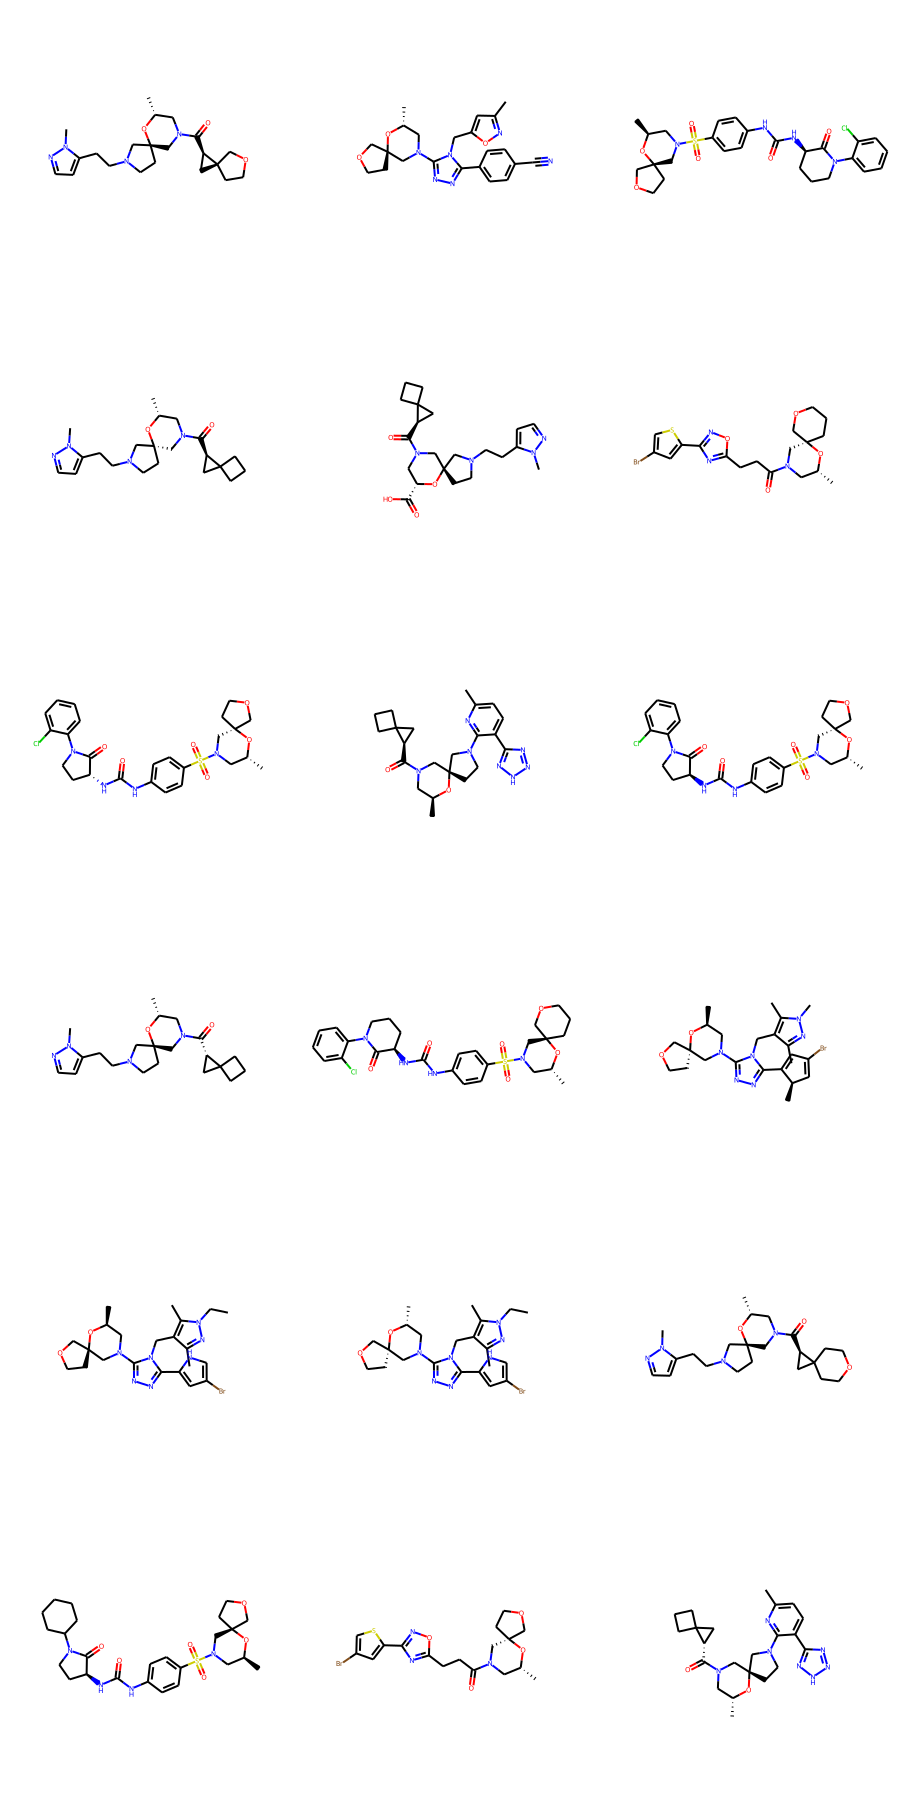

In [ ]:
draw_mols(to_mols(env.log.df[env.log.df.aff>14].samples.values))

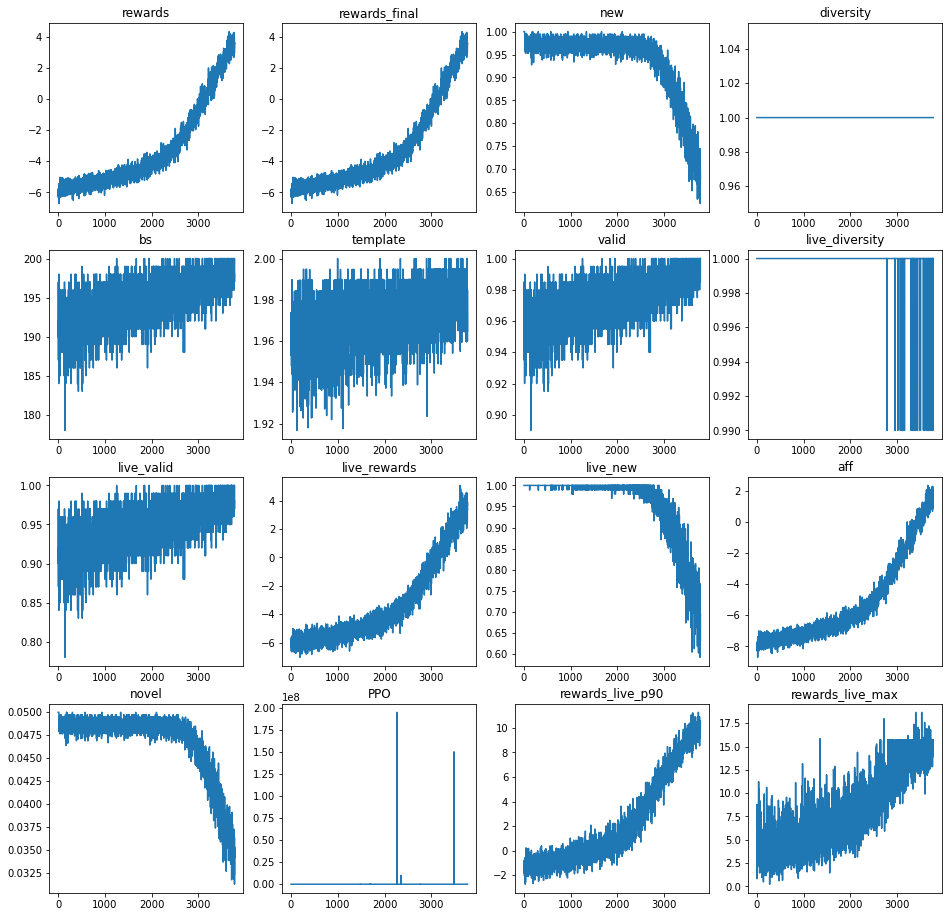

In [ ]:
env.log.plot_metrics()